<a href="https://colab.research.google.com/github/RamanVer1ma/AgroFarm/blob/main/NDWI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ee.Authenticate()
ee.Initialize(project = 'agrofram')

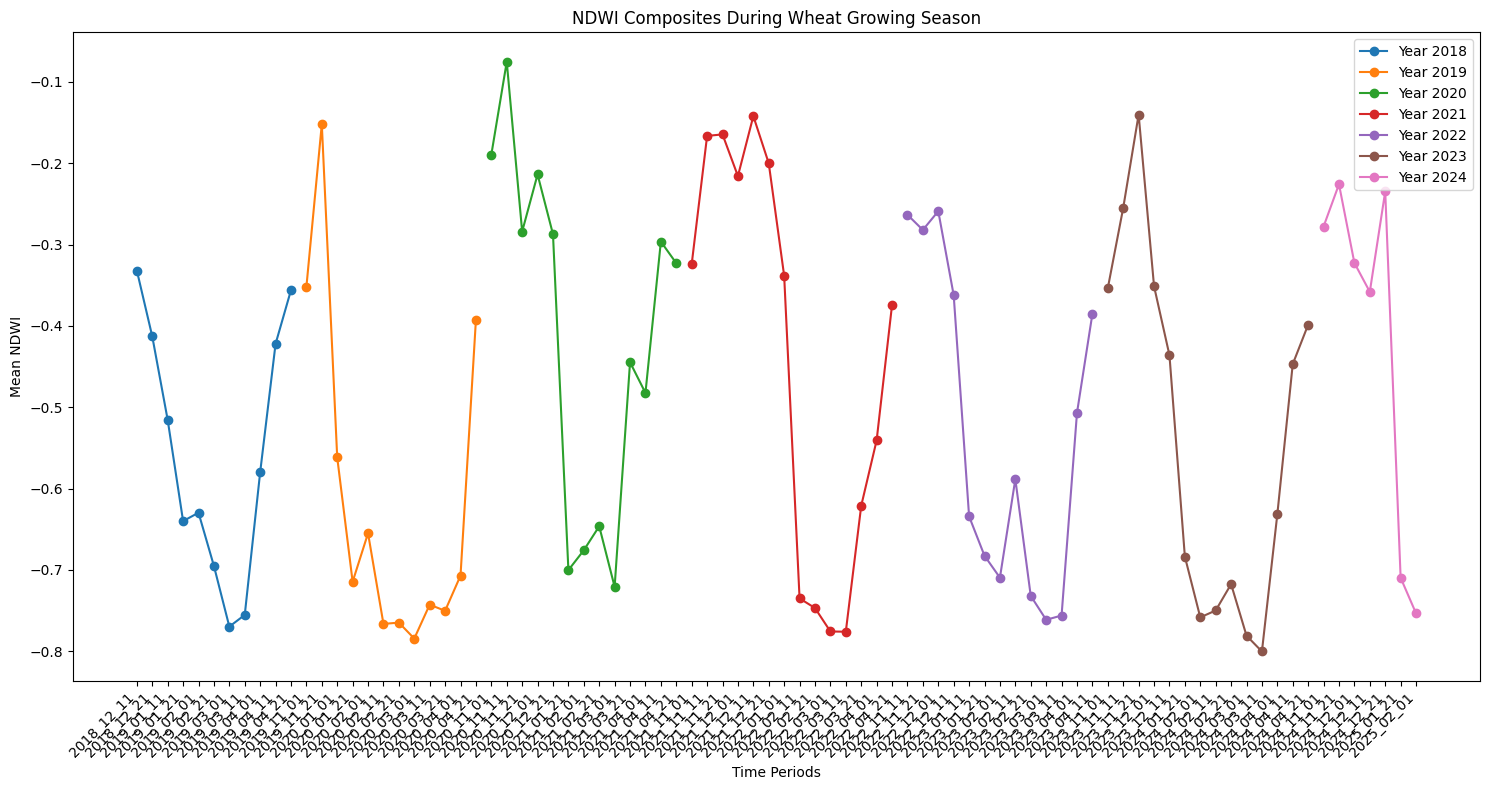

In [2]:


def create_date_ranges(year):
    periods = []
    # Months from November of current year to April of next year
    months_config = [
        (11, year),    # November current year
        (12, year),    # December current year
        (1, year+1),   # January next year
        (2, year+1),   # February next year
        (3, year+1),   # March next year
        (4, year+1)    # April next year
    ]

    for month, year_to_use in months_config:
        for day_start in [1, 11, 21]:
            # Create start and end dates for 10-day periods
            start_date = ee.Date(f'{year_to_use}-{month:02d}-{day_start:02d}')
            end_date = start_date.advance(10, 'day')

            periods.append({
                'start': start_date,
                'end': end_date,
                'label': f'{year_to_use}_{month:02d}_{day_start:02d}'
            })

    return periods

def load_and_process_ndwi(year, region):
    """
    Load Sentinel images and calculate NDWI composites for 5-10 day periods
    """
    # Get date ranges for the year
    periods = create_date_ranges(year)

    ndwi_composites = []

    for period in periods:
        # Load Sentinel-2 images for the period
        collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterDate(period['start'], period['end']) \
            .filterBounds(region) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))

        # If no images, append None
        if collection.size().getInfo() == 0:
            ndwi_composites.append({
                'date': period['label'],
                'ndwi': None
            })
            continue

        # Calculate NDWI composite
        ndwi_composite = collection \
            .map(lambda image: image.normalizedDifference(['B3', 'B8']).rename('NDWI')) \
            .mean()

        # Extract mean NDWI value
        mean_ndwi = ndwi_composite.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10,
            maxPixels=1e9
        ).get('NDWI').getInfo()

        ndwi_composites.append({
            'date': period['label'],
            'ndwi': mean_ndwi
        })

    return ndwi_composites

def plot_ndwi_composites(ndwi_data):
    """
    Plot NDWI composites across years
    """
    plt.figure(figsize=(15, 8))

    # Prepare data for plotting
    all_dates = []
    all_ndwis = []

    for year_data in ndwi_data:
        dates = [entry['date'] for entry in year_data if entry['ndwi'] is not None]
        ndwis = [entry['ndwi'] for entry in year_data if entry['ndwi'] is not None]

        plt.plot(dates, ndwis, marker='o', label=f'Year {dates[0][:4]}')

        all_dates.extend(dates)
        all_ndwis.extend(ndwis)

    plt.title('NDWI Composites During Wheat Growing Season')
    plt.xlabel('Time Periods')
    plt.ylabel('Mean NDWI')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_dates, all_ndwis

def main():
    # Define region of interest (example: Punjab, India)
    xmin, ymin = 75.84399, 30.81936
    xmax, ymax = 75.85511, 30.82714
    punjab = ee.Geometry.Rectangle([75.84399, 30.81936,75.85511, 30.82714])

    # Process NDWI for last 5 years
    ndwi_data = []
    for year in range(2018, 2025):
        year_ndwi = load_and_process_ndwi(year, punjab)
        ndwi_data.append(year_ndwi)

    # Plot NDWI composites
    dates, ndwis = plot_ndwi_composites(ndwi_data)

if __name__ == '__main__':
    main()

In [3]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


def generate_full_timestamp_range(start_year, end_year):
    """
    Generate complete timestamp range for wheat growing season
    """
    timestamps = []
    for year in range(start_year, end_year + 1):
        # Wheat growing season from Nov to May
        current_date = datetime(year, 11, 1)
        season_end = datetime(year + 1, 5, 31)

        while current_date <= season_end:
            timestamps.append(current_date)
            current_date += timedelta(days=10)

    return timestamps

def load_ndwi_for_period(start_date, end_date, region):
    """
    Load Sentinel images and calculate NDWI for specific period
    """
    # Convert datetime to ee.Date
    start = ee.Date(start_date.strftime('%Y-%m-%d'))
    end = ee.Date(end_date.strftime('%Y-%m-%d'))

    # Load Sentinel-2 images
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate(start, end) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))

    # If no images, return None
    if collection.size().getInfo() == 0:
        return None

    # Calculate NDWI composite
    ndwi_composite = collection \
        .map(lambda image: image.normalizedDifference(['B3', 'B8']).rename('NDWI')) \
        .mean()

    # Extract mean NDWI value
    try:
        mean_ndwi = ndwi_composite.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10,
            maxPixels=1e9
        ).get('NDWI').getInfo()
        return mean_ndwi
    except:
        return None

def create_ndwi_dataset(start_year, end_year):
    """
    Create comprehensive NDWI dataset
    """
  # Define region of interest (example: Punjab, India)
    xmin, ymin = 75.84399, 30.81936
    xmax, ymax = 75.85511, 30.82714
    punjab = ee.Geometry.Rectangle([75.84399, 30.81936,75.85511, 30.82714])


    # Generate full timestamp range
    timestamps = generate_full_timestamp_range(start_year, end_year)

    # Prepare data collection
    data = []
    for timestamp in timestamps:
        # 10-day period
        period_end = timestamp + timedelta(days=10)

        # Calculate NDWI
        ndwi = load_ndwi_for_period(timestamp, period_end, punjab)

        data.append({
            'timestamp': timestamp,
            'NDWIi': ndwi
        })

    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month

    return df

def plot_ndwi_dataset(df):
    """
    Plot NDWI dataset with missing values highlighted
    """
    plt.figure(figsize=(15, 8))

    # Group by year and plot
    for year in df['year'].unique():
        year_data = df[df['year'] == year]

        # Plot available NDWI values
        available = year_data[year_data['NDWIi'].notna()]
        plt.plot(available['timestamp'], available['NDWIi'],
                 marker='o', linestyle='-', label=f'Year {year}')

        # Highlight missing values
        missing = year_data[year_data['NDWIi'].isna()]
        if not missing.empty:
            plt.scatter(missing['timestamp'], [0]*len(missing),
                        color='red', marker='x', s=100)

    plt.title('NDWI Time Series with Missing Periods')
    plt.xlabel('Timestamp')
    plt.ylabel('NDWI Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df

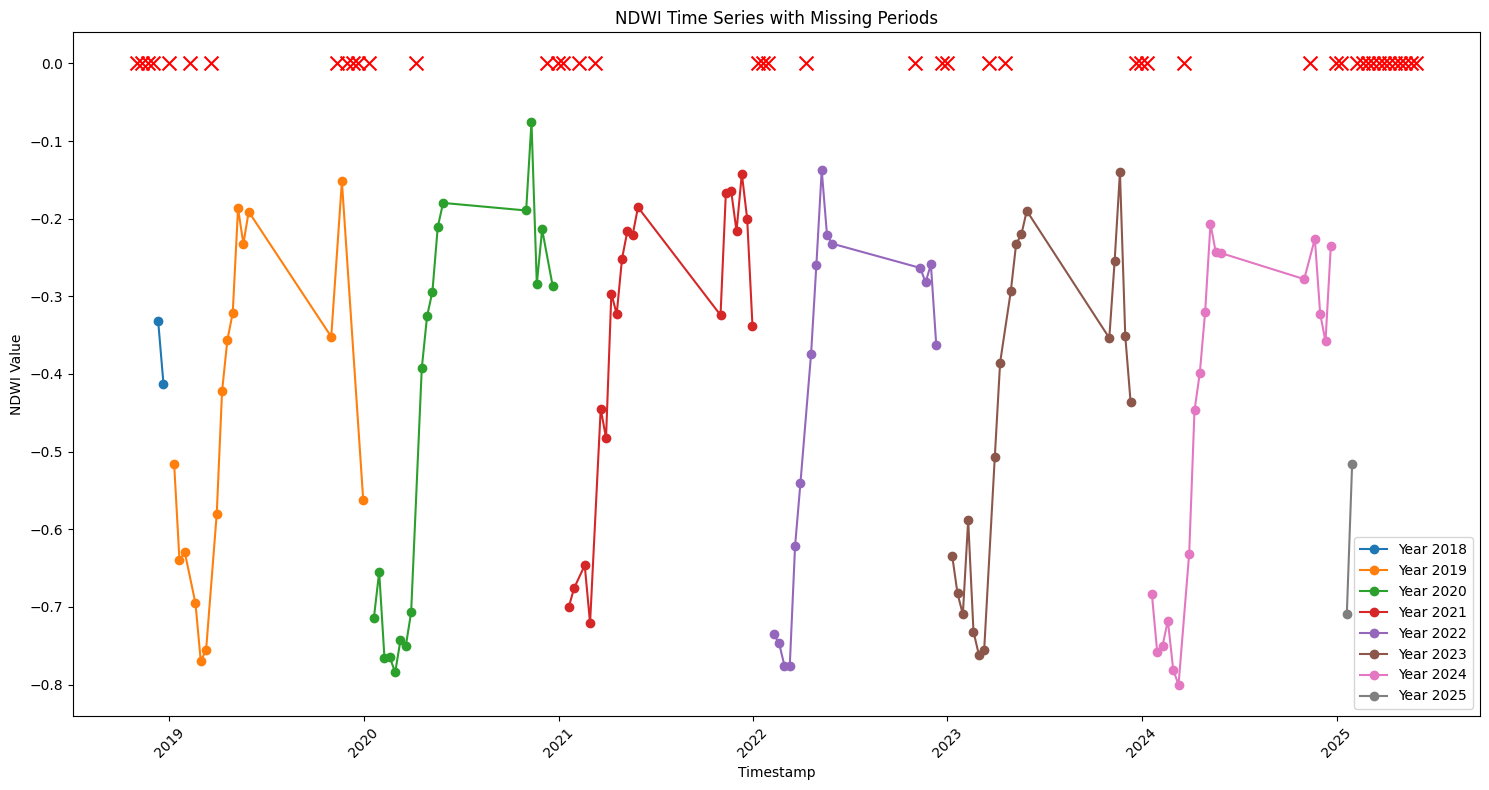

Missing NDWI Periods:
     timestamp  year  month
0   2018-11-01  2018     11
1   2018-11-11  2018     11
2   2018-11-21  2018     11
3   2018-12-01  2018     12
6   2018-12-31  2018     12
10  2019-02-09  2019      2
14  2019-03-21  2019      3
23  2019-11-11  2019     11
25  2019-12-01  2019     12
26  2019-12-11  2019     12
27  2019-12-21  2019     12
29  2020-01-10  2020      1
38  2020-04-09  2020      4
48  2020-12-11  2020     12
50  2020-12-31  2020     12
51  2021-01-10  2021      1
54  2021-02-09  2021      2
57  2021-03-11  2021      3
73  2022-01-10  2022      1
74  2022-01-20  2022      1
75  2022-01-30  2022      1
82  2022-04-10  2022      4
88  2022-11-01  2022     11
93  2022-12-21  2022     12
94  2022-12-31  2022     12
102 2023-03-21  2023      3
105 2023-04-20  2023      4
115 2023-12-21  2023     12
116 2023-12-31  2023     12
117 2024-01-10  2024      1
124 2024-03-20  2024      3
133 2024-11-11  2024     11
138 2024-12-31  2024     12
139 2025-01-10  2025      

In [4]:

 # Generate NDWI dataset
ndwi_df = create_ndwi_dataset(2018, 2024)

    # Plot and display results
result_df = plot_ndwi_dataset(ndwi_df)

    # Print summary of missing data
missing_summary = result_df[result_df['NDWIi'].isna()]
print("Missing NDWI Periods:")
print(missing_summary[['timestamp', 'year', 'month']])



In [5]:
result_df.isna().sum()

,0
timestamp,0
NDWIi,46
year,0
month,0


In [6]:
result_df.drop(result_df[result_df.timestamp > '2025-02-08'].index)

,timestamp,NDWIi,year,month
0,2018-11-01,NaN,2018,11
1,2018-11-11,NaN,2018,11
2,2018-11-21,NaN,2018,11
3,2018-12-01,NaN,2018,12
4,2018-12-11,-0.332074,2018,12
...,...,...,...,...
137,2024-12-21,-0.234755,2024,12
138,2024-12-31,NaN,2024,12
139,2025-01-10,NaN,2025,1
140,2025-01-20,-0.709740,2025,1


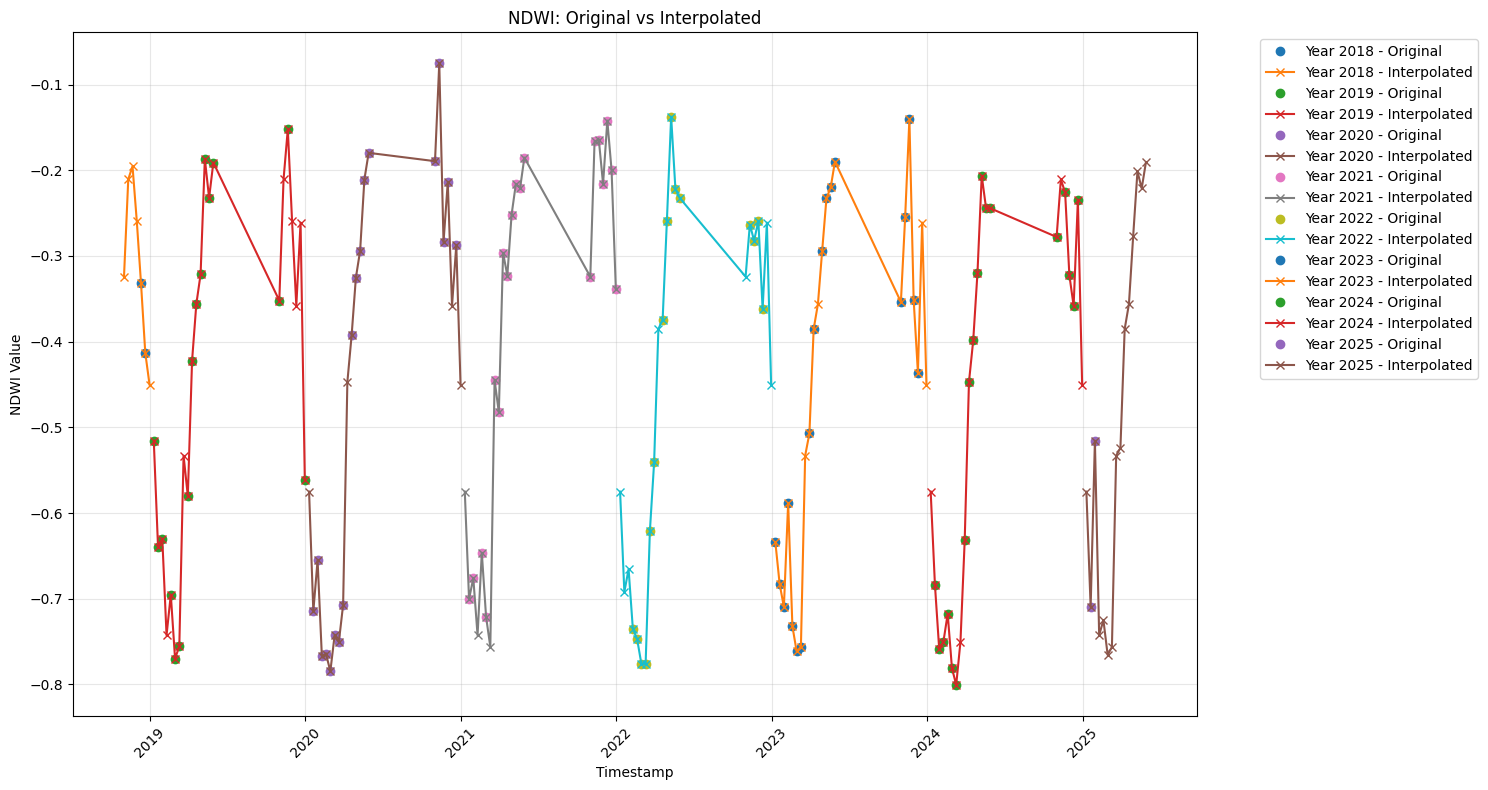

Missing values after interpolation: 0
Total rows in dataset: 154


In [7]:
def interpolate_ndwi(df):
    """
    Interpolate NDWI values with improved seasonal handling and edge cases
    """
    # Create a copy to avoid modifying original data
    df_filtered = df.copy()

    # Convert timestamp to datetime if it isn't already
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])

    # Create seasonal features
    df_filtered['month'] = df_filtered['timestamp'].dt.month
    df_filtered['day'] = df_filtered['timestamp'].dt.day
    df_filtered['day_of_year'] = df_filtered['timestamp'].dt.dayofyear

    # Calculate seasonal medians for each day-month combination
    seasonal_medians = df_filtered.groupby(['month', 'day'])['NDWIi'].transform('median')

    # First pass: Fill missing values with seasonal medians
    df_filtered['NDWIi_interpolated'] = df_filtered['NDWIi'].fillna(seasonal_medians)

    # Second pass: Apply linear interpolation within each year
    for year in df_filtered['year'].unique():
        year_mask = df_filtered['year'] == year
        df_filtered.loc[year_mask, 'NDWIi_interpolated'] = (
            df_filtered.loc[year_mask, 'NDWIi_interpolated']
            .interpolate(method='linear', limit_direction='forward', limit=30)  # Limit to 30 days forward
        )

    # Third pass: Fill any remaining NaN with seasonal patterns
    remaining_nans = df_filtered['NDWIi_interpolated'].isna()
    if remaining_nans.any():
        # Calculate the average NDWI pattern across all years
        seasonal_pattern = (
            df_filtered.groupby('day_of_year')['NDWIi']
            .mean()
            .interpolate(method='cubic')  # Smooth the seasonal pattern
        )

        # Fill remaining NaNs with the seasonal pattern
        for idx in df_filtered[remaining_nans].index:
            day_of_year = df_filtered.loc[idx, 'day_of_year']
            df_filtered.loc[idx, 'NDWIi_interpolated'] = seasonal_pattern[day_of_year]

    # Visualization
    plt.figure(figsize=(15, 8))

    # Plot original and interpolated data by year
    years = df_filtered['year'].unique()
    for year in years:
        year_data = df_filtered[df_filtered['year'] == year]

        plt.plot(year_data['timestamp'], year_data['NDWIi'],
                marker='o', linestyle='', label=f'Year {year} - Original')
        plt.plot(year_data['timestamp'], year_data['NDWIi_interpolated'],
                marker='x', linestyle='-', label=f'Year {year} - Interpolated')

    plt.title('NDWI: Original vs Interpolated')
    plt.xlabel('Timestamp')
    plt.ylabel('NDWI Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df_filtered

# Usage
result = interpolate_ndwi(result_df)
print("Missing values after interpolation:", result['NDWIi_interpolated'].isna().sum())
print("Total rows in dataset:", len(result))

In [8]:
print(result['NDWIi_interpolated'].isna())

0      False
1      False
2      False
3      False
4      False
       ...  
149    False
150    False
151    False
152    False
153    False
Name: NDWIi_interpolated, Length: 154, dtype: bool


In [9]:
print(result)

     timestamp     NDWIi  year  month  day  day_of_year  NDWIi_interpolated
0   2018-11-01       NaN  2018     11    1          305           -0.324220
1   2018-11-11       NaN  2018     11   11          315           -0.210697
2   2018-11-21       NaN  2018     11   21          325           -0.195246
3   2018-12-01       NaN  2018     12    1          335           -0.258981
4   2018-12-11 -0.332074  2018     12   11          345           -0.332074
..         ...       ...   ...    ...  ...          ...                 ...
149 2025-04-20       NaN  2025      4   20          110           -0.356102
150 2025-04-30       NaN  2025      4   30          120           -0.276432
151 2025-05-10       NaN  2025      5   10          130           -0.201394
152 2025-05-20       NaN  2025      5   20          140           -0.221167
153 2025-05-30       NaN  2025      5   30          150           -0.190412

[154 rows x 7 columns]


In [10]:
result = result.drop(columns= ['day'])
result = result.drop(columns= ['NDWIi'])
result = result.drop(columns= ['day_of_year'])
print(result)

     timestamp  year  month  NDWIi_interpolated
0   2018-11-01  2018     11           -0.324220
1   2018-11-11  2018     11           -0.210697
2   2018-11-21  2018     11           -0.195246
3   2018-12-01  2018     12           -0.258981
4   2018-12-11  2018     12           -0.332074
..         ...   ...    ...                 ...
149 2025-04-20  2025      4           -0.356102
150 2025-04-30  2025      4           -0.276432
151 2025-05-10  2025      5           -0.201394
152 2025-05-20  2025      5           -0.221167
153 2025-05-30  2025      5           -0.190412

[154 rows x 4 columns]


In [11]:
print("Input data shape:", result.shape)
print("Columns:", result.columns)
print("First few rows:\n", result.head())

Input data shape: (154, 4)
Columns: Index(['timestamp', 'year', 'month', 'NDWIi_interpolated'], dtype='object')
First few rows:
    timestamp  year  month  NDWIi_interpolated
0 2018-11-01  2018     11           -0.324220
1 2018-11-11  2018     11           -0.210697
2 2018-11-21  2018     11           -0.195246
3 2018-12-01  2018     12           -0.258981
4 2018-12-11  2018     12           -0.332074


In [12]:
def analyze_ndwi_cycles(df, cutoff_date='2025-02-08', min_change=0.02, consecutive_changes=2):
    df = df.sort_values('timestamp').reset_index(drop=True)

    cycles = []
    for year in df['year'].unique():
        season_data = df[
            (df['timestamp'] >= f"{year}-11-01") &
            (df['timestamp'] <= f"{year+1}-05-31")
        ].copy()

        if len(season_data) < 3:
            continue

        season_data = season_data.reset_index(drop=True)
        season_data['ndwi_change'] = season_data['NDWIi_interpolated'].diff()
        season_data['ndwi_rolling'] = season_data['NDWIi_interpolated'].rolling(3, center=True).mean()

        # Get sowing period
        sowing_period = season_data[season_data['timestamp'].dt.month == 11].iloc[0]

        # Find growth initiation (looking for decrease in NDWI)
        growth_start_idx = None
        for i in range(len(season_data) - consecutive_changes + 1):
            if (season_data['ndwi_change'].iloc[i:i+consecutive_changes] < -min_change).all():
                growth_start_idx = i
                break

        if growth_start_idx is None:
            baseline = season_data['NDWIi_interpolated'].iloc[0:3].mean()
            for i in range(len(season_data)):
                if season_data['NDWIi_interpolated'].iloc[i] < (baseline - 0.1):
                    growth_start_idx = i
                    break

        if growth_start_idx is None:
            growth_start_idx = 0

        # Find trough (minimum NDWI) after growth initiation
        trough_data = season_data.iloc[growth_start_idx:]
        if len(trough_data) > 0:
            trough_idx = trough_data['NDWIi_interpolated'].idxmin()
            trough_row = season_data.loc[trough_idx]
        else:
            trough_row = season_data.iloc[-1]

        # Calculate days ensuring correct temporal sequence
        sowing_to_growth = (season_data.iloc[growth_start_idx]['timestamp'] - sowing_period['timestamp']).days
        growth_to_trough = (trough_row['timestamp'] - season_data.iloc[growth_start_idx]['timestamp']).days

        # Ensure growth_to_trough is not negative
        if growth_to_trough < 0:
            trough_idx = season_data.iloc[growth_start_idx:]['NDWIi_interpolated'].idxmin()
            trough_row = season_data.loc[trough_idx]
            growth_to_trough = (trough_row['timestamp'] - season_data.iloc[growth_start_idx]['timestamp']).days

        cycles.append({
            'growing_season': f"{year}-{year+1}",
            'sowing_date': sowing_period['timestamp'],
            'sowing_ndwi': sowing_period['NDWIi_interpolated'],
            'growth_initiation_date': season_data.iloc[growth_start_idx]['timestamp'],
            'growth_initiation_ndwi': season_data.iloc[growth_start_idx]['NDWIi_interpolated'],
            'trough_date': trough_row['timestamp'],
            'trough_ndwi': trough_row['NDWIi_interpolated'],
            'season_length_days': 210,  # Fixed season length
            'sowing_to_growth_days': max(0, sowing_to_growth),  # Ensure non-negative
            'growth_to_trough_days': max(0, growth_to_trough)  # Ensure non-negative
        })

    return pd.DataFrame(cycles)

def plot_ndwi_cycles(df, cycles_df):
    plt.figure(figsize=(15, 8))
    for _, cycle in cycles_df.iterrows():
        season_start = cycle['sowing_date']
        season_end = pd.to_datetime(season_start) + pd.Timedelta(days=210)

        season_data = df[
            (df['timestamp'] >= season_start) &
            (df['timestamp'] <= season_end)
        ]

        plt.plot(season_data['timestamp'], season_data['NDWIi_interpolated'],
                label=cycle['growing_season'])

        plt.scatter(cycle['growth_initiation_date'], cycle['growth_initiation_ndwi'],
                   marker='^', s=100, label=f"{cycle['growing_season']} Growth Start")              ## Can't find the down arrow
        plt.scatter(cycle['trough_date'], cycle['trough_ndwi'],
                   marker='*', s=100, label=f"{cycle['growing_season']} Trough")

    plt.title('NDWI Cycles with Detected Growth Points and Troughs')
    plt.xlabel('Date')
    plt.ylabel('NDWI')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

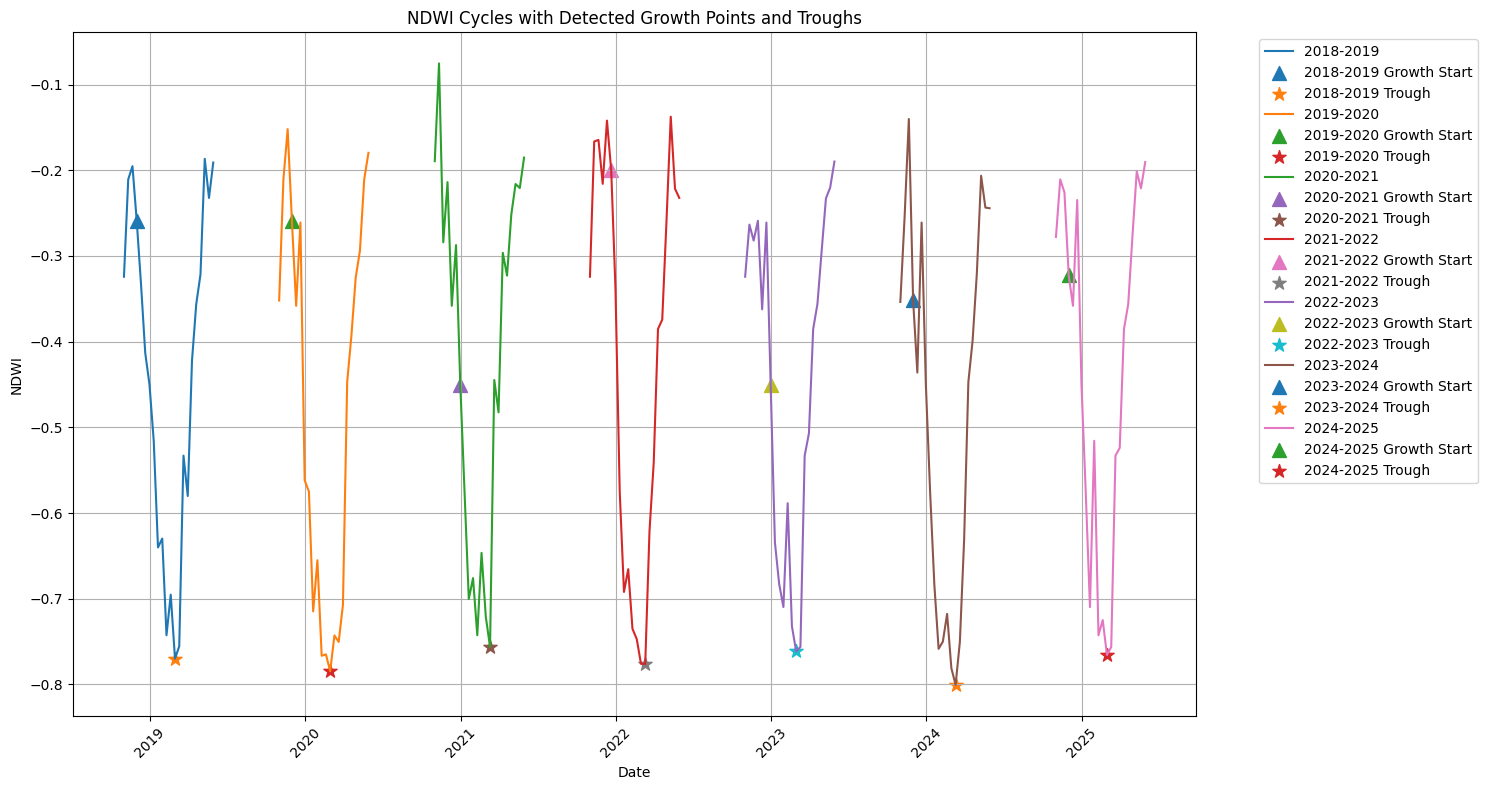


Crop Cycle Analysis with Growth Initiation:
  growing_season sowing_date  sowing_ndwi growth_initiation_date  \
0      2018-2019  2018-11-01    -0.324220             2018-12-01   
1      2019-2020  2019-11-01    -0.352068             2019-12-01   
2      2020-2021  2020-11-01    -0.189432             2020-12-31   
3      2021-2022  2021-11-01    -0.324220             2021-12-21   
4      2022-2023  2022-11-01    -0.324220             2022-12-31   
5      2023-2024  2023-11-01    -0.353672             2023-12-01   
6      2024-2025  2024-11-01    -0.277870             2024-12-01   

   growth_initiation_ndwi trough_date  trough_ndwi  season_length_days  \
0               -0.258981  2019-03-01    -0.769795                 210   
1               -0.258981  2020-02-29    -0.784512                 210   
2               -0.450049  2021-03-11    -0.756174                 210   
3               -0.200106  2022-03-11    -0.776070                 210   
4               -0.450049  2023-03-01   

In [13]:
# Make sure your timestamps are in datetime format
result['timestamp'] = pd.to_datetime(result['timestamp'])

# Run the analysis
cycles = analyze_ndwi_cycles(result)
plot_ndwi_cycles(result, cycles)
print("\nCrop Cycle Analysis with Growth Initiation:")
print(cycles)

In [14]:

cycles = cycles.drop(6)  # 2025 season is not still completed , incomplete data can cause deviation in mean values


In [15]:
sowing_period_time = cycles['sowing_to_growth_days'].sum()
total_years = 6
avg_sowing_period = sowing_period_time / total_years
print(f"Average sowing period: {avg_sowing_period:.2f} days")

Average sowing period: 43.33 days


In [16]:
growth_period_time = cycles['growth_to_trough_days'].sum()
total_years = 6
avg_growth_period = growth_period_time / total_years
avg_growth_period += avg_sowing_period
print(f"Average growth period: {avg_growth_period:.2f} days")

Average growth period: 125.00 days


In [17]:
harvest_period_time = cycles['season_length_days'].sum()
total_years = 6
avg_harvest_period = harvest_period_time / total_years
avg_harvest_period -= 30       # We are considering april as harvesting time period
print(f"Average harvest period: {avg_harvest_period:.2f} days")

Average harvest period: 180.00 days


In [18]:
threshold_ndwi = cycles['growth_initiation_ndwi'].mean()
print(f"Threshold NDWI for growth initiation: {threshold_ndwi:.3f}")

Threshold NDWI for growth initiation: -0.328


In [19]:
trough_ndwi = cycles['trough_ndwi'].max()
print(f"Peak NDWI for peak: {trough_ndwi:.3f}")

Peak NDWI for peak: -0.756


In [20]:
min_ndwi = cycles['sowing_ndwi'].mean()
print(f"Minimum NDWI for sowing: {min_ndwi:.3f}")

Minimum NDWI for sowing: -0.311


In [21]:
print("NDWI Data Statistics:")
print(result['NDWIi_interpolated'].describe())
print("\nStandard Deviation:", result['NDWIi_interpolated'].std())

NDWI Data Statistics:
count    154.000000
mean      -0.444825
std        0.211871
min       -0.800398
25%       -0.662851
50%       -0.385268
75%       -0.258981
max       -0.075344
Name: NDWIi_interpolated, dtype: float64

Standard Deviation: 0.21187100311944382


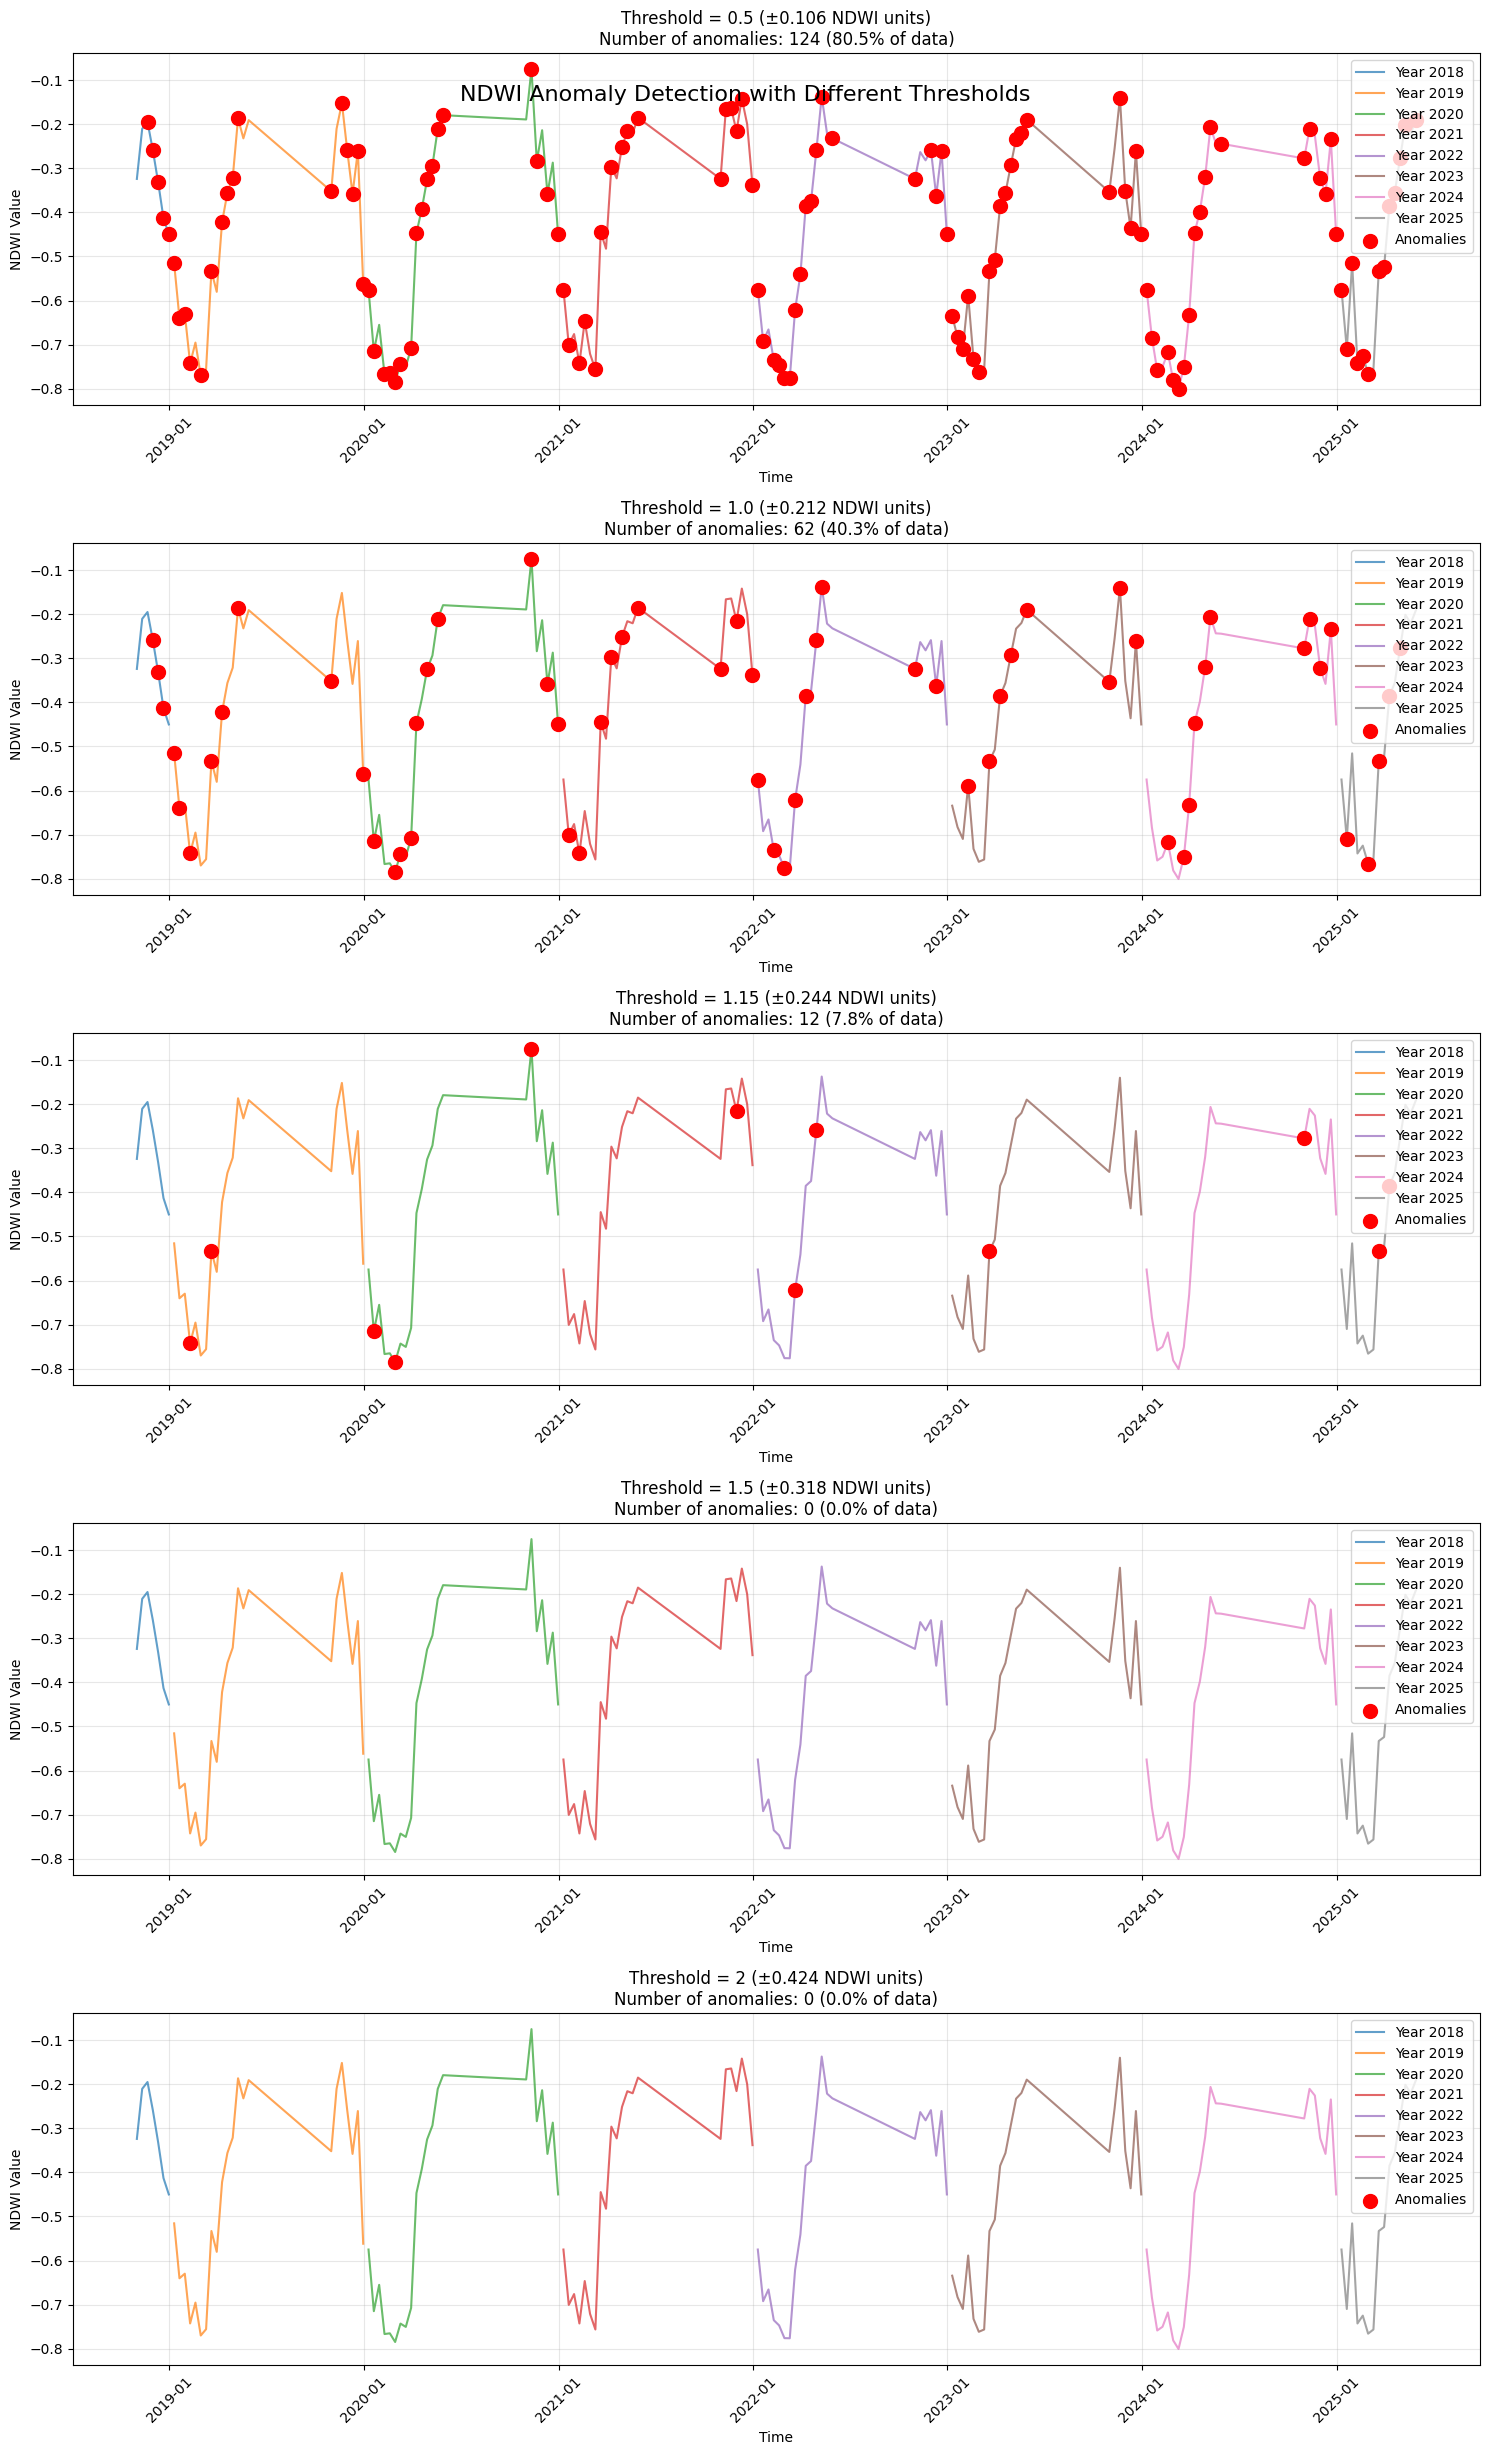


Detailed Threshold Analysis:
---------------------------

Threshold: 0.5
Allowed deviation: ±0.106 NDWI units
Number of anomalies: 124.0
Percentage of data flagged: 80.5%
Interpretation: Too sensitive

Threshold: 1.0
Allowed deviation: ±0.212 NDWI units
Number of anomalies: 62.0
Percentage of data flagged: 40.3%
Interpretation: Too sensitive

Threshold: 1.15
Allowed deviation: ±0.244 NDWI units
Number of anomalies: 12.0
Percentage of data flagged: 7.8%
Interpretation: Good sensitivity

Threshold: 1.5
Allowed deviation: ±0.318 NDWI units
Number of anomalies: 0.0
Percentage of data flagged: 0.0%
Interpretation: May miss anomalies

Threshold: 2.0
Allowed deviation: ±0.424 NDWI units
Number of anomalies: 0.0
Percentage of data flagged: 0.0%
Interpretation: May miss anomalies

NDWI Data Distribution:
----------------------
count    154.000000
mean      -0.444825
std        0.211871
min       -0.800398
25%       -0.662851
50%       -0.385268
75%       -0.258981
max       -0.075344
Name: NDW

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def analyze_threshold_impacts(df, thresholds=[0.5, 1.0, 1.15, 1.5, 2]):
    std_dev = df['NDWIi_interpolated'].std()
    window_size = 3

    # Create figure
    fig, axs = plt.subplots(len(thresholds), 1, figsize=(15, 5*len(thresholds)))
    fig.suptitle('NDWI Anomaly Detection with Different Thresholds', fontsize=16, y=0.95)

    results = []

    for idx, threshold in enumerate(thresholds):
        # Calculate rolling statistics
        rolling_mean = df['NDWIi_interpolated'].rolling(window=window_size).mean()
        rolling_std = df['NDWIi_interpolated'].rolling(window=window_size).std()

        # Define bounds
        upper_bound = rolling_mean + (threshold * rolling_std)
        lower_bound = rolling_mean - (threshold * rolling_std)

        # Detect anomalies
        anomalies = df[
            (df['NDWIi_interpolated'] > upper_bound) |
            (df['NDWIi_interpolated'] < lower_bound)
        ]

        # Calculate actual deviation range
        actual_deviation = threshold * std_dev

        # Store results
        results.append({
            'threshold': threshold,
            'num_anomalies': len(anomalies),
            'percentage': (len(anomalies) / len(df)) * 100,
            'deviation_range': actual_deviation
        })

        # Plot
        ax = axs[idx]

        # Plot original NDWI
        for year in df['year'].unique():
            year_data = df[df['year'] == year]
            ax.plot(year_data['timestamp'], year_data['NDWIi_interpolated'],
                   label=f'Year {year}', alpha=0.7)

        # Plot anomalies
        ax.scatter(anomalies['timestamp'], anomalies['NDWIi_interpolated'],
                  color='red', s=100, label='Anomalies', zorder=5)

        ax.set_title(f'Threshold = {threshold} (±{actual_deviation:.3f} NDWI units)\n'
                    f'Number of anomalies: {len(anomalies)} ({(len(anomalies)/len(df)*100):.1f}% of data)')
        ax.set_xlabel('Time')
        ax.set_ylabel('NDWI Value')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Format dates
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    results_df = pd.DataFrame(results)
    print("\nDetailed Threshold Analysis:")
    print("---------------------------")
    for _, row in results_df.iterrows():
        print(f"\nThreshold: {row['threshold']}")
        print(f"Allowed deviation: ±{row['deviation_range']:.3f} NDWI units")
        print(f"Number of anomalies: {row['num_anomalies']}")
        print(f"Percentage of data flagged: {row['percentage']:.1f}%")
        print(f"Interpretation: {'Too sensitive' if row['percentage'] > 20 else 'Good sensitivity' if 5 <= row['percentage'] <= 20 else 'May miss anomalies'}")

# Run the analysis
analyze_threshold_impacts(result)

# Print basic NDWI statistics for reference
print("\nNDWI Data Distribution:")
print("----------------------")
stats = result['NDWIi_interpolated'].describe()
print(stats)
print(f"\nStandard Deviation: {result['NDWIi_interpolated'].std():.3f}")

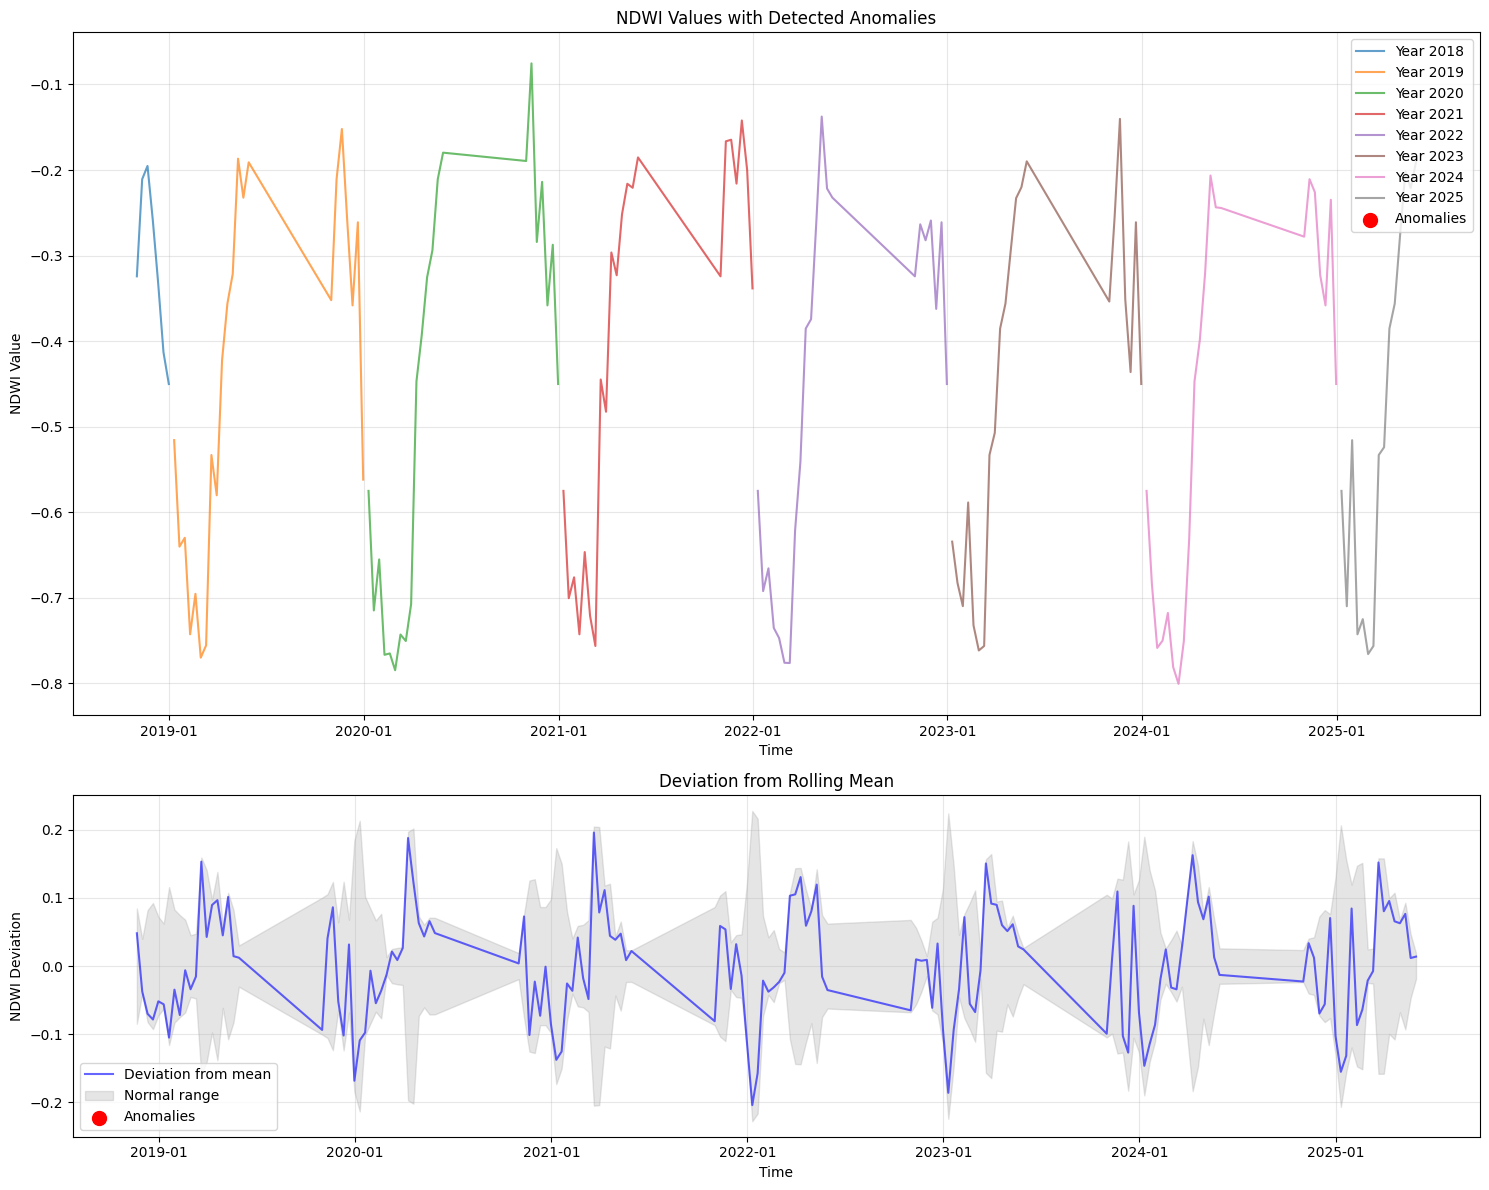


Anomaly Statistics:
Total number of anomalies detected: 0


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def detect_and_plot_anomalies(df, window_size=3, std_threshold = 1.2):
    # Calculate rolling statistics
    rolling_mean = df['NDWIi_interpolated'].rolling(window=window_size).mean()
    rolling_std = df['NDWIi_interpolated'].rolling(window=window_size).std()

    # Define upper and lower bounds
    upper_bound = rolling_mean + (std_threshold * rolling_std)
    lower_bound = rolling_mean - (std_threshold * rolling_std)

    # Detect anomalies
    anomalies = df[
        (df['NDWIi_interpolated'] > upper_bound) |
        (df['NDWIi_interpolated'] < lower_bound)
    ]

    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])

    # Plot 1: Original NDWI with anomalies
    for year in df['year'].unique():
        year_data = df[df['year'] == year]
        ax1.plot(year_data['timestamp'], year_data['NDWIi_interpolated'],
                 label=f'Year {year}', alpha=0.7)

    # Highlight anomalies
    ax1.scatter(anomalies['timestamp'], anomalies['NDWIi_interpolated'],
                color='red', s=100, label='Anomalies', zorder=5)

    ax1.set_title('NDWI Values with Detected Anomalies')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('NDWI Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Deviation from rolling mean
    deviation = df['NDWIi_interpolated'] - rolling_mean
    ax2.plot(df['timestamp'], deviation, label='Deviation from mean', color='blue', alpha=0.6)
    ax2.fill_between(df['timestamp'],
                     -std_threshold * rolling_std,
                     std_threshold * rolling_std,
                     color='gray', alpha=0.2, label='Normal range')

    # Highlight anomalous deviations
    anomalous_deviations = deviation[
        (df['NDWIi_interpolated'] > upper_bound) |
        (df['NDWIi_interpolated'] < lower_bound)
    ]
    ax2.scatter(anomalous_deviations.index,
                anomalous_deviations.values,
                color='red', s=100, label='Anomalies', zorder=5)

    ax2.set_title('Deviation from Rolling Mean')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('NDWI Deviation')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Format dates on x-axis
    date_formatter = DateFormatter("%Y-%m")
    ax1.xaxis.set_major_formatter(date_formatter)
    ax2.xaxis.set_major_formatter(date_formatter)

    plt.tight_layout()
    plt.show()

    # Print anomaly statistics
    print("\nAnomaly Statistics:")
    print(f"Total number of anomalies detected: {len(anomalies)}")
    if not anomalies.empty:
          print("\nAnomalous dates and values:")
    for idx, row in anomalies.iterrows():
        print(f"Date: {row['timestamp'].strftime('%Y-%m-%d')}, "
              f"NDWI: {row['NDWIi_interpolated']:.3f}")

    return anomalies

# Use the function
anomalies = detect_and_plot_anomalies(result)

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def prepare_data(df, seq_length=6):  # 6 time steps = 60 days of history
    # Separate training (2019-2023) and testing (2024) data
    train_data = df[df['year'] < 2024]['NDWIi_interpolated'].values
    test_data = df[df['year'] >= 2024]['NDWIi_interpolated'].values

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))

    # Create sequences
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    return X_train, y_train, X_test, y_test, scaler

def build_lstm_model(seq_length):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_predictions(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Calculate accuracy as 1 - normalized RMSE
    accuracy = 1 - (rmse / (np.max(y_true) - np.min(y_true)))

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Accuracy': accuracy
    }

def plot_results(actual, predicted, title='NDWI Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', marker='o')
    plt.plot(predicted, label='Predicted', marker='x')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('NDWI')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
def train_and_evaluate(df):
    # Prepare data
    X_train, y_train, X_test, y_test, scaler = prepare_data(df)

    # Build and train model
    model = build_lstm_model(X_train.shape[1])
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Inverse transform predictions
    train_pred = scaler.inverse_transform(train_pred)
    test_pred = scaler.inverse_transform(test_pred)
    y_train_orig = scaler.inverse_transform(y_train)
    y_test_orig = scaler.inverse_transform(y_test)

    # Evaluate model
    train_metrics = evaluate_predictions(y_train_orig, train_pred)
    test_metrics = evaluate_predictions(y_test_orig, test_pred)

    # Plot results
    plot_results(y_test_orig, test_pred, 'NDWI Predictions for 2024 (Test Set)')

    return train_metrics, test_metrics, model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - loss: 0.3385 - val_loss: 0.2944
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.3225 - val_loss: 0.2824
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3195 - val_loss: 0.2679
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.3006 - val_loss: 0.2530
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2692 - val_loss: 0.2384
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2615 - val_loss: 0.2228
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2529 - val_loss: 0.2049
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2223 - val_loss: 0.1845
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1982 - val_loss: 0.1613
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1840 - val_loss: 0.1350
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1506 - val_loss: 0.1066
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1342 - val_l

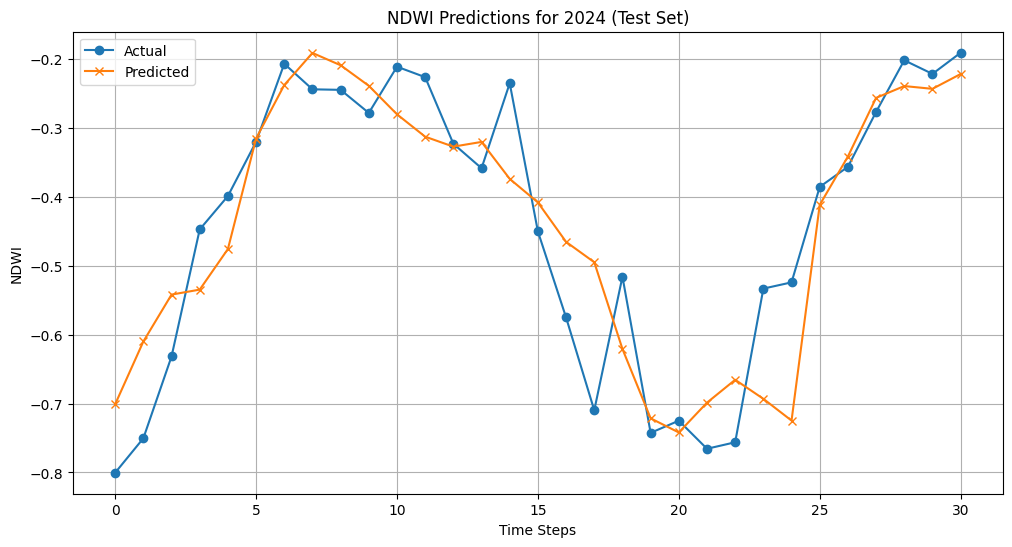


Training Metrics: {'RMSE': 0.08878275800372662, 'MAE': 0.06925784468637554, 'R2': 0.8228620285834395, 'Accuracy': 0.8748070774544554}

Test Metrics: {'RMSE': 0.08899746751377254, 'MAE': 0.07016401658817328, 'R2': 0.8100772638006497, 'Accuracy': 0.8540991210771647}


In [25]:
train_metrics, test_metrics, model = train_and_evaluate(result)
print("\nTraining Metrics:", train_metrics)
print("\nTest Metrics:", test_metrics)

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
import matplotlib.pyplot as plt

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def prepare_data(df, seq_length=6):
    train_data = df[df['year'] < 2024]['NDWIi_interpolated'].values
    test_data = df[df['year'] >= 2024]['NDWIi_interpolated'].values

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))

    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    return X_train, y_train, X_test, y_test, scaler

def build_bilstm_model(seq_length):
    model = Sequential([
        Bidirectional(LSTM(64, activation='relu', return_sequences=True),
                     input_shape=(seq_length, 1)),
        Dropout(0.2),
        Bidirectional(LSTM(32, activation='relu')),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model(seq_length):
    model = Sequential([
        GRU(64, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
        Dropout(0.2),
        GRU(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_predictions(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    accuracy = 1 - (rmse / (np.max(y_true) - np.min(y_true)))

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Accuracy': accuracy
    }

def plot_results(actual, predicted, title='NDWI Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', marker='o')
    plt.plot(predicted, label='Predicted', marker='x')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('NDWI')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_and_evaluate(df, model_type='bilstm'):
    # Prepare data
    X_train, y_train, X_test, y_test, scaler = prepare_data(df)

    # Select model type
    if model_type.lower() == 'bilstm':
        model = build_bilstm_model(X_train.shape[1])
        model_name = 'Bidirectional LSTM'
    elif model_type.lower() == 'gru':
        model = build_gru_model(X_train.shape[1])
        model_name = 'GRU'
    else:
        raise ValueError("Model type must be 'bilstm' or 'gru'")

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Inverse transform predictions
    train_pred = scaler.inverse_transform(train_pred)
    test_pred = scaler.inverse_transform(test_pred)
    y_train_orig = scaler.inverse_transform(y_train)
    y_test_orig = scaler.inverse_transform(y_test)

    # Evaluate model
    train_metrics = evaluate_predictions(y_train_orig, train_pred)
    test_metrics = evaluate_predictions(y_test_orig, test_pred)

    # Plot results
    plot_results(y_test_orig, test_pred, f'NDWI Predictions for 2024 using {model_name} (Test Set)')

    return train_metrics, test_metrics, model, history

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 468ms/step - loss: 0.3230 - val_loss: 0.2754
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3094 - val_loss: 0.2538
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2621 - val_loss: 0.2273
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2328 - val_loss: 0.1958
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2040 - val_loss: 0.1582
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1745 - val_loss: 0.1169
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1244 - val_loss: 0.0786
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0944 - val_loss: 0.0596
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0720 - val_loss: 0.0736
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0961 - val_loss: 0.0773
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0907 - val_loss: 0.0658
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0836 - val_loss: 0.0581


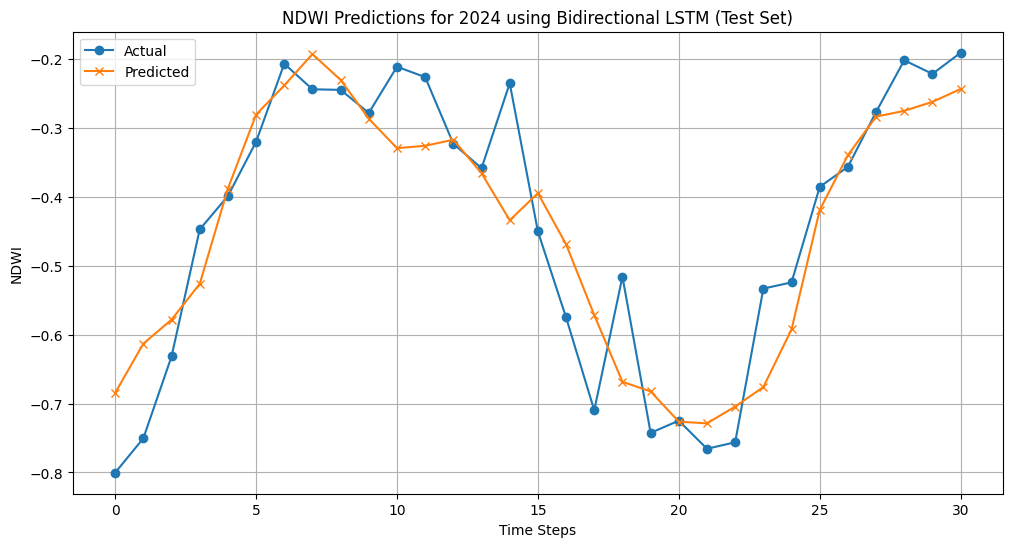

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - loss: 0.2939 - val_loss: 0.2345
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2607 - val_loss: 0.1830
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1961 - val_loss: 0.1371
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1583 - val_loss: 0.0981
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1095 - val_loss: 0.0697
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0952 - val_loss: 0.0559
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0714 - val_loss: 0.0590
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0785 - val_loss: 0.0658
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0852 - val_loss: 0.0634
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0689 - val_loss: 0.0571
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0713 - val_loss: 0.0530
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0602 - val_loss: 0.0522


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


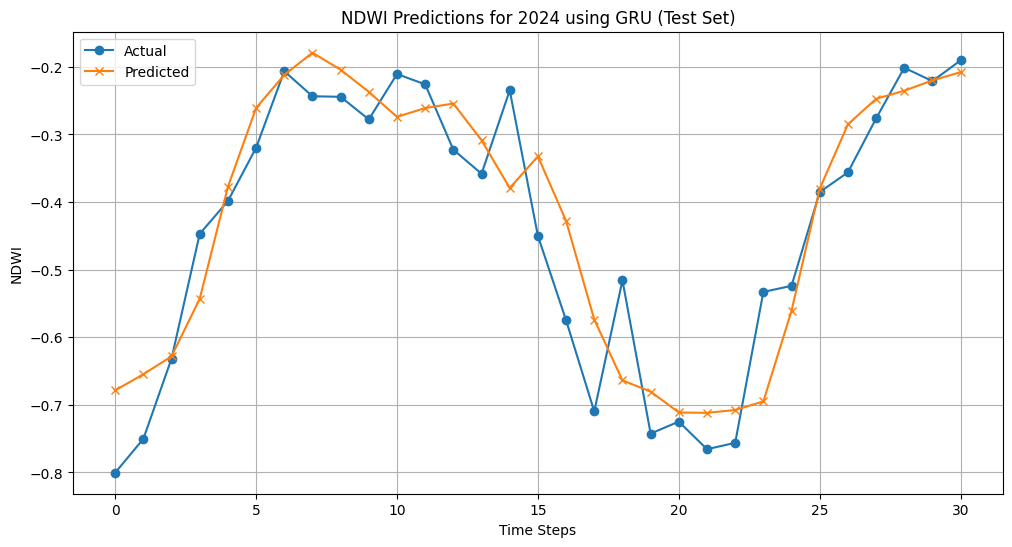


Bidirectional LSTM Test Metrics:
RMSE: 0.0826
MAE: 0.0648
R2: 0.8364
Accuracy: 0.8646

GRU Test Metrics:
RMSE: 0.0799
MAE: 0.0642
R2: 0.8469
Accuracy: 0.8690


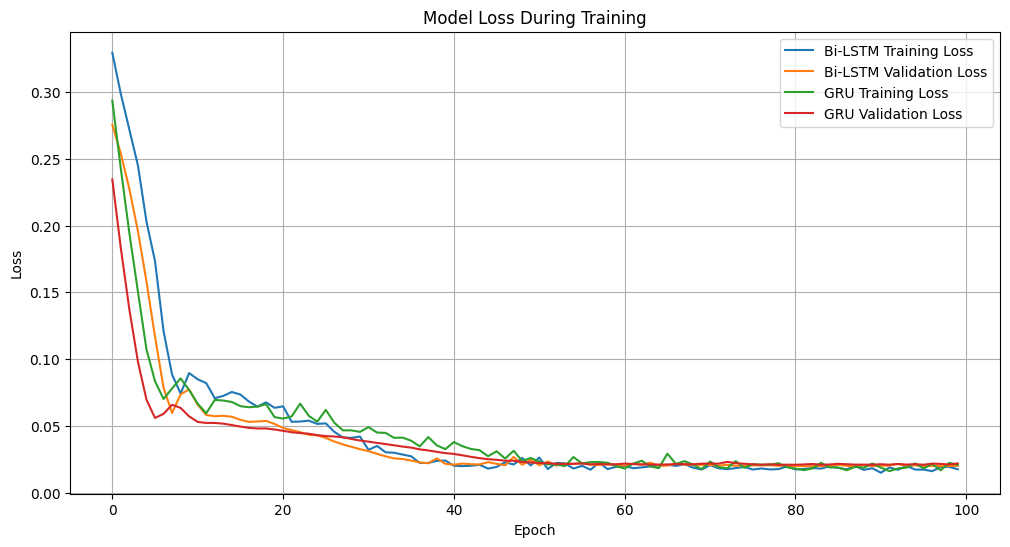

In [27]:
# For Bidirectional LSTM
bilstm_train_metrics, bilstm_test_metrics, bilstm_model, bilstm_history = train_and_evaluate(result, model_type='bilstm')

# For GRU
gru_train_metrics, gru_test_metrics, gru_model, gru_history = train_and_evaluate(result, model_type='gru')

# Print metrics for comparison
print("\nBidirectional LSTM Test Metrics:")
for metric, value in bilstm_test_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nGRU Test Metrics:")
for metric, value in gru_test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(bilstm_history.history['loss'], label='Bi-LSTM Training Loss')
plt.plot(bilstm_history.history['val_loss'], label='Bi-LSTM Validation Loss')
plt.plot(gru_history.history['loss'], label='GRU Training Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Bidirectional processing allows the model to learn from both past and future context for each time step, which is particularly useful for NDWI patterns that might have seasonal dependencies.

In [28]:
def forecast_future(model, last_sequence, scaler, n_days=10):
    """
    Forecast future NDWI values using the trained Bi-LSTM model

    Parameters:
    model: trained Bi-LSTM model
    last_sequence: last known sequence of NDWI values
    scaler: fitted MinMaxScaler
    n_days: number of days to forecast
    """
    predictions = []
    current_sequence = last_sequence.copy()

    # Make predictions for n_days
    for _ in range(n_days):
        # Reshape sequence for model input
        current_sequence_scaled = scaler.transform(current_sequence.reshape(-1, 1))
        X = current_sequence_scaled.reshape(1, len(current_sequence), 1)

        # Predict next value
        next_pred_scaled = model.predict(X, verbose=0)
        next_pred = scaler.inverse_transform(next_pred_scaled)[0][0]

        # Append prediction
        predictions.append(next_pred)

        # Update sequence for next prediction
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred

    return np.array(predictions)

def plot_forecast(historical_data, forecasted_values, last_n_days=30):
    """
    Plot historical data and forecasted values
    """
    plt.figure(figsize=(12, 6))

    # Plot last n days of historical data
    historical_values = historical_data[-last_n_days:]
    plt.plot(range(len(historical_values)), historical_values,
             label='Historical', marker='o')

    # Plot forecasted values
    plt.plot(range(len(historical_values)-1, len(historical_values) + len(forecasted_values)),
             [historical_values[-1]] + list(forecasted_values),
             label='Forecast', marker='x', color='red')

    plt.axvline(x=len(historical_values)-1, color='gray', linestyle='--',
                label='Forecast Start')

    plt.title('NDWI Forecast for Next 10 Days')
    plt.xlabel('Time Steps')
    plt.ylabel('NDWI')
    plt.legend()
    plt.grid(True)
    plt.show()

# Make predictions using the trained model
def predict_future_ndwi(df, trained_model, seq_length=6, forecast_days=1):
    """
    Main function to prepare data and make future predictions
    """
    # Prepare the last known sequence
    last_known_values = df['NDWIi_interpolated'].values[-seq_length:]

    # Get the scaler
    all_values = df['NDWIi_interpolated'].values
    scaler = MinMaxScaler()
    scaler.fit(all_values.reshape(-1, 1))

    # Make predictions
    future_predictions = forecast_future(trained_model, last_known_values,
                                       scaler, forecast_days)

    # Create dates for predictions
    last_date = pd.to_datetime(df['timestamp'].iloc[-1])
    future_dates = [last_date + pd.Timedelta(days=i+1) for i in range(forecast_days)]

    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_NDWI': future_predictions
    })

    # Plot results
    plot_forecast(df['NDWIi_interpolated'].values, future_predictions)

    return forecast_df

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 416ms/step - loss: 0.3126 - val_loss: 0.2669
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3002 - val_loss: 0.2344
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2528 - val_loss: 0.1972
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2028 - val_loss: 0.1569
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1599 - val_loss: 0.1148
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1301 - val_loss: 0.0770
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0856 - val_loss: 0.0584
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0760 - val_loss: 0.0718
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0817 - val_loss: 0.0792
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0958 - val_loss: 0.0652
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0700 - val_loss: 0.0567
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0709 - val_l

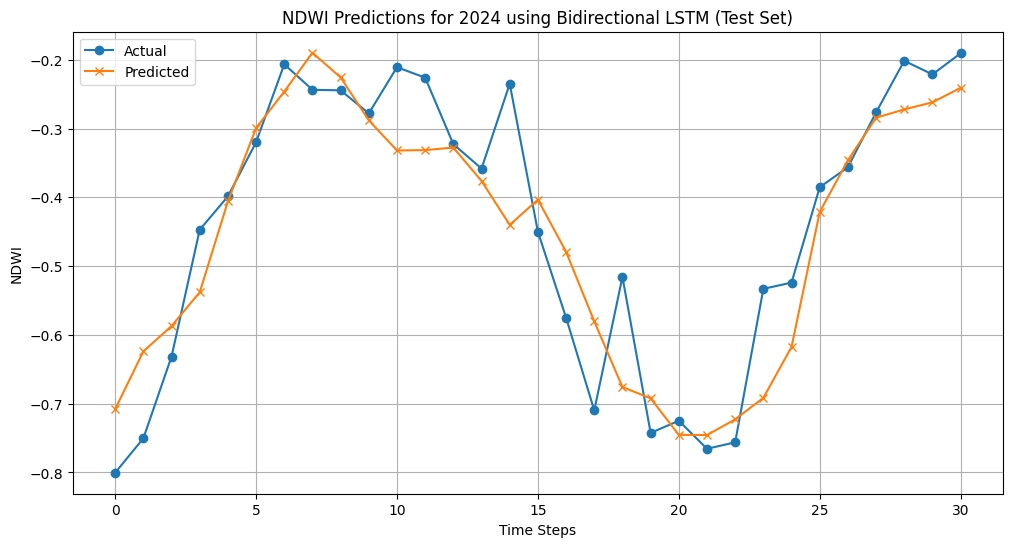

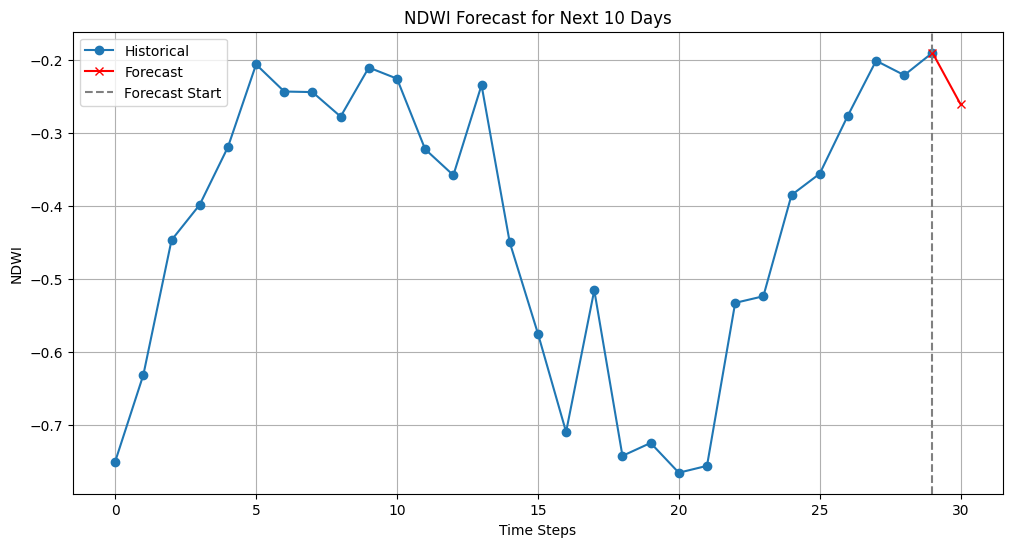


Forecasted NDWI values for the next 10 days:
      Date  Predicted_NDWI
2025-05-31       -0.261171


In [29]:
# First train the Bi-LSTM model if you haven't already
bilstm_train_metrics, bilstm_test_metrics, bilstm_model, bilstm_history = train_and_evaluate(result, model_type='bilstm')

# Then make predictions for the next 10 days
forecast_df = predict_future_ndwi(result, bilstm_model)

# Print the forecasted values
print("\nForecasted NDWI values for the next 10 days:")
print(forecast_df.to_string(index=False))

In [30]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Save NDWI predictions to CSV
forecast_df.to_csv('/content/drive/My Drive/NDWI_predictions.csv', index=False)



Mounted at /content/drive
Results saved to /content/drive/My Drive/NDWI_results.txt


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Prepare results as text
results = f"""Average sowing period: {avg_sowing_period:.2f} days
Average growth period: {avg_growth_period:.2f} days
Average harvest period: {avg_harvest_period:.2f} days
Threshold NDWI for growth initiation: {threshold_ndwi:.3f}
Peak NDWI for peak: {trough_ndwi:.3f}
Minimum NDWI for sowing: {min_ndwi:.3f}
"""

# Save to a text file in Google Drive
file_path = "/content/drive/My Drive/NDWI_results.txt"
with open(file_path, "w") as file:
    file.write(results)

print(f"Results saved to {file_path}")
